# DeepLife Cell Segmentation project


In [1]:
!pip install segmentation-models-pytorch -q
!pip install albumentations -q
!pip install -U albumentations -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Setup

In [2]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import skimage.io
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore # CHANGED: Import from .utils.metrics
import albumentations as A
from albumentations.pytorch import ToTensorV2
# from tqdm import tqdm
from tqdm.notebook import tqdm # NOTE: For Colab

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
path_to_training="/content/drive/MyDrive/DeepLife-Project/archive/Training.zip"
path_to_test = "/content/drive/MyDrive/DeepLife-Project/archive/Tuning_preprocessed.zip"
data_dir="/content/data"
!mkdir data_dir

mkdir: cannot create directory ‘data_dir’: File exists


In [9]:
import zipfile
z = zipfile.ZipFile(path_to_test)
z.extractall(data_dir)
#"""
z = zipfile.ZipFile(path_to_training)
z.extractall(data_dir)
#"""

In [10]:
# Set global variables

# TIP: You can create a shortcut of the official dataset to your MyDrive folder
# https://drive.google.com/drive/folders/1NFplvkQzc_nHFwpnB55lw2nD6coc91VV?usp=drive_link
DATA_DIR = "/data/"

TRAIN_IMG_DIR = f"data/Training/images/"
TRAIN_LBL_DIR = f"data/Training/labels/"
TEST_IMG_DIR = f"data/Tuning/images/"
TEST_LBL_DIR = f"data/Tuning/labels/"
MODEL_SAVE_PATH = "swinunet_celldet_best.pth"


In [ ]:
import os
import skimage.io
import numpy as np
from glob import glob

def check_images(directory, name):
    print(f"\n🔍 Checking images in: {directory}")
    image_paths = sorted(glob(os.path.join(directory, "*.tif")))

    for path in image_paths:
        img = skimage.io.imread(path)
        dtype = img.dtype
        min_val = img.min()
        max_val = img.max()
        print(f"{name} - {os.path.basename(path)} | dtype: {dtype}, min: {min_val}, max: {max_val}")

# Check training and test images
check_images(TRAIN_IMG_DIR, "TRAIN")
check_images(TEST_IMG_DIR, "TEST")


🔍 Checking images in: data/Training/images/
TRAIN - cell_00142.tif | dtype: uint16, min: 8444, max: 13523
TRAIN - cell_00143.tif | dtype: uint16, min: 9565, max: 14480
TRAIN - cell_00144.tif | dtype: uint16, min: 28240, max: 50316
TRAIN - cell_00231.tif | dtype: uint16, min: 10194, max: 65535
TRAIN - cell_00232.tif | dtype: uint16, min: 10278, max: 65535
TRAIN - cell_00233.tif | dtype: uint16, min: 12184, max: 65535
TRAIN - cell_00234.tif | dtype: uint16, min: 12853, max: 65535
TRAIN - cell_00235.tif | dtype: uint16, min: 16870, max: 65535
TRAIN - cell_00236.tif | dtype: uint16, min: 10808, max: 65535
TRAIN - cell_00237.tif | dtype: uint16, min: 11760, max: 65535
TRAIN - cell_00238.tif | dtype: uint16, min: 7516, max: 65535
TRAIN - cell_00239.tif | dtype: uint16, min: 2652, max: 39420
TRAIN - cell_00240.tif | dtype: uint16, min: 3722, max: 65535
TRAIN - cell_00241.tif | dtype: uint16, min: 3277, max: 35259
TRAIN - cell_00242.tif | dtype: uint16, min: 2126, max: 43628
TRAIN - cell_0024

In [11]:
# Set device
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using CUDA GPU device.")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    DEVICE = torch.device("mps")
    print("Using MPS device.")
else:
    DEVICE = torch.device("cpu")
    print("No GPU or MPS available, using CPU device.")

print(f"Final selected device: {DEVICE}")

Using CUDA GPU device.
Final selected device: cuda


In [12]:
#newww
from torch.utils.data import Dataset
import numpy as np
import skimage.io
import os
import glob

class CellDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.tif")))
        self.label_dir = label_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        base_name = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(self.label_dir, f"{base_name}_label.tiff")

        image = skimage.io.imread(img_path)
        label = skimage.io.imread(label_path)

        # Force grayscale (H, W, 1)
        if image.ndim == 2:
            image = np.expand_dims(image, axis=-1)
        elif image.ndim == 3 and image.shape[-1] > 1:
            image = image[..., 0:1]  # take first channel

        image = image.astype(np.float32)  # albumentations needs float

        # Process label to 2D binary mask
        if label.ndim == 3:
            if label.shape[0] <= 4 and label.shape[0] < label.shape[1]:
                label = np.any(label > 0, axis=0)
            elif label.shape[-1] <= 4 and label.shape[-1] < label.shape[0]:
                label = np.any(label > 0, axis=-1)
            else:
                raise ValueError(f"Unexpected label shape: {label.shape}")
        elif label.ndim != 2:
            raise ValueError(f"Unsupported label ndim={label.ndim}")

        label = (label > 0).astype(np.uint8)

        if self.transform:
            augmented = self.transform(image=image, mask=label)
            image = augmented['image']         # tensor (1, H, W)
            label = augmented['mask'].long()   # tensor (H, W)

        return image, label

In [13]:
#neww
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_transforms(height, width, is_train=True):
    if is_train:
        transform = A.Compose([
            A.Resize(height, width),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.RandomBrightnessContrast(p=0.4),
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
            A.ElasticTransform(p=0.2, alpha=120, sigma=6),
            A.Normalize(mean=(0.5,), std=(0.5,)),  # for grayscale
            ToTensorV2(),
        ])
    else:
        transform = A.Compose([
            A.Resize(height, width),
            A.Normalize(mean=(0.5,), std=(0.5,)),  # for grayscale
            ToTensorV2(),
        ])
    return transform

In [14]:
%%writefile swin_unet_gray.py

import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from einops import rearrange
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

class MoEFFNGating(nn.Module):
    def __init__(self, dim, hidden_dim, num_experts):
        super(MoEFFNGating, self).__init__()
        self.gating_network = nn.Linear(dim, dim)
        self.experts = nn.ModuleList([nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)) for _ in range(num_experts)])

    def forward(self, x):
        weights = self.gating_network(x)
        weights = torch.nn.functional.softmax(weights, dim=-1)
        outputs = [expert(x) for expert in self.experts]
        outputs = torch.stack(outputs, dim=0)
        outputs = (weights.unsqueeze(0) * outputs).sum(dim=0)
        return outputs


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class PatchExpand(nn.Module):
    def __init__(self, input_resolution, dim, dim_scale=2, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.expand = nn.Linear(dim, 2 * dim, bias=False) if dim_scale == 2 else nn.Identity()
        self.norm = norm_layer(dim // dim_scale)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        x = self.expand(x)
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = x.view(B, H, W, C)
        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=2, p2=2, c=C // 4)
        x = x.view(B, -1, C // 4)
        x = self.norm(x)

        return x


class FinalPatchExpand_X4(nn.Module):
    def __init__(self, input_resolution, dim, dim_scale=4, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.dim_scale = dim_scale
        self.expand = nn.Linear(dim, 16 * dim, bias=False)
        self.output_dim = dim
        self.norm = norm_layer(self.output_dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        x = self.expand(x)
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        x = x.view(B, H, W, C)
        x = rearrange(x, 'b h w (p1 p2 c)-> b (h p1) (w p2) c', p1=self.dim_scale, p2=self.dim_scale,
                      c=C // (self.dim_scale ** 2))
        x = x.view(B, -1, self.output_dim)
        x = self.norm(x)

        return x


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class BasicLayer_up(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        upsample (nn.Module | None, optional): upsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, upsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if upsample is not None:
            self.upsample = PatchExpand(input_resolution, dim=dim, dim_scale=2, norm_layer=norm_layer)
        else:
            self.upsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.upsample is not None:
            x = self.upsample(x)
        return x


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops


class SwinTransformerSys(nn.Module):
    r""" Swin Transformer
        A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows`  -
          https://arxiv.org/pdf/2103.14030

    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 2, 2], depths_decoder=[1, 2, 2, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, final_upsample="expand_first", **kwargs):
        super().__init__()

        print(
            "SwinTransformerSys expand initial----depths:{};depths_decoder:{};drop_path_rate:{};num_classes:{}".format(
                depths,
                depths_decoder, drop_path_rate, num_classes))

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.num_features_up = int(embed_dim * 2)
        self.mlp_ratio = mlp_ratio
        self.final_upsample = final_upsample

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build encoder and bottleneck layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               drop=drop_rate, attn_drop=attn_drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               use_checkpoint=use_checkpoint)
            self.layers.append(layer)

        # build decoder layers
        self.layers_up = nn.ModuleList()
        self.concat_back_dim = nn.ModuleList()
        for i_layer in range(self.num_layers):
            concat_linear = nn.Linear(2 * int(embed_dim * 2 ** (self.num_layers - 1 - i_layer)),
                                      int(embed_dim * 2 ** (
                                                  self.num_layers - 1 - i_layer))) if i_layer > 0 else nn.Identity()
            if i_layer == 0:
                layer_up = PatchExpand(
                    input_resolution=(patches_resolution[0] // (2 ** (self.num_layers - 1 - i_layer)),
                                      patches_resolution[1] // (2 ** (self.num_layers - 1 - i_layer))),
                    dim=int(embed_dim * 2 ** (self.num_layers - 1 - i_layer)), dim_scale=2, norm_layer=norm_layer)
            else:
                layer_up = BasicLayer_up(dim=int(embed_dim * 2 ** (self.num_layers - 1 - i_layer)),
                                         input_resolution=(
                                         patches_resolution[0] // (2 ** (self.num_layers - 1 - i_layer)),
                                         patches_resolution[1] // (2 ** (self.num_layers - 1 - i_layer))),
                                         depth=depths[(self.num_layers - 1 - i_layer)],
                                         num_heads=num_heads[(self.num_layers - 1 - i_layer)],
                                         window_size=window_size,
                                         mlp_ratio=self.mlp_ratio,
                                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                                         drop=drop_rate, attn_drop=attn_drop_rate,
                                         drop_path=dpr[sum(depths[:(self.num_layers - 1 - i_layer)]):sum(
                                             depths[:(self.num_layers - 1 - i_layer) + 1])],
                                         norm_layer=norm_layer,
                                         upsample=PatchExpand if (i_layer < self.num_layers - 1) else None,
                                         use_checkpoint=use_checkpoint)
            self.layers_up.append(layer_up)
            self.concat_back_dim.append(concat_linear)

        self.norm = norm_layer(self.num_features)
        self.norm_up = norm_layer(self.embed_dim)

        if self.final_upsample == "expand_first":
            print("---final upsample expand_first---")
            self.up = FinalPatchExpand_X4(input_resolution=(img_size // patch_size, img_size // patch_size),
                                          dim_scale=4, dim=embed_dim)
            self.output = nn.Conv2d(in_channels=embed_dim, out_channels=self.num_classes, kernel_size=1, bias=False)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    # Encoder and Bottleneck
    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)
        x_downsample = []

        for layer in self.layers:
            x_downsample.append(x)
            x = layer(x)

        x = self.norm(x)  # B L C

        return x, x_downsample

    # Dencoder and Skip connection
    def forward_up_features(self, x, x_downsample):
        for inx, layer_up in enumerate(self.layers_up):
            if inx == 0:
                x = layer_up(x)
            else:
                x = torch.cat([x, x_downsample[3 - inx]], -1)
                x = self.concat_back_dim[inx](x)
                x = layer_up(x)

        x = self.norm_up(x)  # B L C

        return x

    def up_x4(self, x):
        H, W = self.patches_resolution
        B, L, C = x.shape
        assert L == H * W, "input features has wrong size"

        if self.final_upsample == "expand_first":
            x = self.up(x)
            x = x.view(B, 4 * H, 4 * W, -1)
            x = x.permute(0, 3, 1, 2)  # B,C,H,W
            x = self.output(x)

        return x

    def forward(self, x):
        x, x_downsample = self.forward_features(x)
        x = self.forward_up_features(x, x_downsample)
        x = self.up_x4(x)

        return x

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
        flops += self.num_features * self.num_classes
        return flops


Writing swin_unet_gray.py


In [19]:
#po optunie
from swin_unet_gray import SwinTransformerSys
import torch.nn as nn

def get_model(img_size=448, in_channels=1, classes=2):
    model = SwinTransformerSys(
        img_size=img_size,
        patch_size=4,
        in_chans=in_channels,
        num_classes=classes,
        embed_dim=96,                            # Updated from 128 → 96
        depths=[2, 2, 2, 2],                      # Already correct
        depths_decoder=[1, 2, 2, 2],              # Keep as-is
        num_heads=[3, 6, 12, 24],                 # Updated from [4, 8, 16, 32]
        window_size=7,
        mlp_ratio=4.,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        norm_layer=nn.LayerNorm,
        ape=False,
        patch_norm=True,
        use_checkpoint=False,
        final_upsample="expand_first"
    )
    return model

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 22.8 MB/s eta 0:00:00


In [ ]:
!pip install segmentation-models-pytorch

In [15]:
import torch.nn.functional as F

def sliding_window_inference(image, model, patch_size=448, stride=224, device="cuda"):
    model.eval()
    _, H, W = image.shape  # [C, H, W]

    # Pad to ensure full coverage
    pad_h = (patch_size - H % patch_size) % patch_size
    pad_w = (patch_size - W % patch_size) % patch_size
    image_padded = F.pad(image.unsqueeze(0), (0, pad_w, 0, pad_h), mode='reflect').squeeze(0)

    _, H_pad, W_pad = image_padded.shape
    output = torch.zeros((model.num_classes, H_pad, W_pad)).to(device)
    count_map = torch.zeros((1, H_pad, W_pad)).to(device)

    # Slide window
    for y in range(0, H_pad - patch_size + 1, stride):
        for x in range(0, W_pad - patch_size + 1, stride):
            patch = image_padded[:, y:y+patch_size, x:x+patch_size].unsqueeze(0).to(device)
            with torch.no_grad():
                pred = model(patch)  # (B, C, H, W)
                pred = pred.squeeze(0)

            output[:, y:y+patch_size, x:x+patch_size] += pred
            count_map[:, y:y+patch_size, x:x+patch_size] += 1

    output = output / count_map
    output = output[:, :H, :W]  # crop to original size

    return output

In [16]:
#new with sliding window
# Training Function
def train_one_epoch(model, loader, optimizer, loss_fn, metrics_fns, device):
    model.train()
    loop = tqdm(loader, desc="Training")

    epoch_loss = 0.0
    epoch_iou = 0.0
    epoch_fscore = 0.0

    for batch_idx, (images, masks) in enumerate(loop):
        images = images.to(device)
        masks = masks.to(device) # Shape (B, H, W)

        optimizer.zero_grad()
        predictions = model(images) # Shape (B, C, H, W)

        # DEBUG: Print shapes before metric calculation
        if batch_idx == 0: # Print only for the first batch to avoid clutter
            print(f"DEBUG: predictions.shape: {predictions.shape}") # Expected: (B, 2, H, W)
            print(f"DEBUG: masks.shape: {masks.shape}")             # Expected: (B, H, W)
            print(f"DEBUG: masks.dtype: {masks.dtype}")           # Expected: torch.int64 (long)
            if masks.numel() > 0:
                 print(f"DEBUG: masks min/max values: {masks.min()}, {masks.max()}") # Expected: 0, 1

        loss = loss_fn(predictions, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Calculate metrics
        # For multiclass, metrics expect predictions as logits/probs and masks as class indices
        masks_one_hot = torch.nn.functional.one_hot(masks, num_classes=2).permute(0, 3, 1, 2).float()
        iou_score = metrics_fns['iou'](predictions, masks_one_hot)
        f_score = metrics_fns['fscore'](predictions, masks_one_hot)

        epoch_iou += iou_score.item()
        epoch_fscore += f_score.item()

        loop.set_postfix(loss=loss.item(), iou=iou_score.item(), fscore=f_score.item())

    avg_loss = epoch_loss / len(loader)
    avg_iou = epoch_iou / len(loader)
    avg_fscore = epoch_fscore / len(loader)
    return avg_loss, avg_iou, avg_fscore

def validate_one_epoch_sliding(model, dataset, loss_fn, metrics_fns, device, patch_size=448, stride=224):
    model.eval()
    epoch_loss = 0.0
    epoch_iou = 0.0
    epoch_fscore = 0.0

    for i in tqdm(range(len(dataset)), desc="Sliding Validation"):
        image, mask = dataset[i]
        image, mask = image.to(device), mask.to(device)

        # Sliding inference
        pred_logits = sliding_window_inference(image, model, patch_size, stride, device)
        pred_logits = pred_logits.unsqueeze(0)  # [1, C, H, W]
        mask = mask.unsqueeze(0)  # [1, H, W]

        # Loss
        loss = loss_fn(pred_logits, mask)
        epoch_loss += loss.item()

        # Metrics
        mask_onehot = torch.nn.functional.one_hot(mask, num_classes=2).permute(0, 3, 1, 2).float()
        iou_score = metrics_fns['iou'](pred_logits, mask_onehot)
        f_score = metrics_fns['fscore'](pred_logits, mask_onehot)

        epoch_iou += iou_score.item()
        epoch_fscore += f_score.item()

    avg_loss = epoch_loss / len(dataset)
    avg_iou = epoch_iou / len(dataset)
    avg_fscore = epoch_fscore / len(dataset)

    return avg_loss, avg_iou, avg_fscore

In [17]:
# Create datasets with augmentations
train_transform = get_transforms(IMG_HEIGHT, IMG_WIDTH, is_train=True)
val_test_transform = get_transforms(IMG_HEIGHT, IMG_WIDTH, is_train=False)

train_dataset = CellDataset(TRAIN_IMG_DIR, TRAIN_LBL_DIR, transform=train_transform)
val_dataset = CellDataset(TEST_IMG_DIR, TEST_LBL_DIR, transform=val_test_transform)
test_dataset = CellDataset(TEST_IMG_DIR, TEST_LBL_DIR, transform=val_test_transform)

print(f"Found {len(train_dataset)} training images.")
print(f"Found {len(val_dataset)} validation/test images.")

if not train_dataset or not val_dataset:
    print("Error: Empty dataset. Check image paths and data directories.")
    exit()


Found 447 training images.
Found 31 validation/test images.


<ipython-input-13-3ea4491033ab>:13: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


In [20]:
# New Training
LEARNING_RATE = 1e-5
BATCH_SIZE = 2
NUM_EPOCHS = 25
IMG_HEIGHT = 448
IMG_WIDTH = 448
Weight_decay = 5.4e-05

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
# val_loader is no longer used with sliding window inference
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Initialize model, loss, optimizer, metrics
model = get_model()
model = model.to(DEVICE)

loss_fn = DiceLoss(mode='multiclass', from_logits=True)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=Weight_decay)

metrics = {
    "iou": IoU(threshold=0.5, activation="softmax2d"),
    "fscore": Fscore(threshold=0.5, activation="softmax2d")
}

best_val_iou = 0.0

# Lists for tracking
train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_fscores, val_fscores = [], []

print(f"Starting training for {NUM_EPOCHS} epochs on {DEVICE}...")

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

    train_loss, train_iou, train_fscore = train_one_epoch(
        model, train_loader, optimizer, loss_fn, metrics, DEVICE
    )
    print(f"Train -> Loss: {train_loss:.4f}, IoU: {train_iou:.4f}, F-score: {train_fscore:.4f}")

    #  SLIDING WINDOW VALIDATION
    val_loss, val_iou, val_fscore = validate_one_epoch_sliding(
        model, val_dataset, loss_fn, metrics, DEVICE
    )
    print(f"Val   -> Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, F-score: {val_fscore:.4f}")

    # Track metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_ious.append(train_iou)
    val_ious.append(val_iou)
    train_fscores.append(train_fscore)
    val_fscores.append(val_fscore)

    # Save model if improved
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"Model saved to {MODEL_SAVE_PATH} (Best Val IoU: {best_val_iou:.4f})")

SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:2


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---final upsample expand_first---
Starting training for 25 epochs on cuda...

Epoch 1/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.5100, IoU: 0.7385, F-score: 0.8403


Sliding Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Val   -> Loss: 0.5172, IoU: 0.7561, F-score: 0.8410
Model saved to swinunet_celldet_best.pth (Best Val IoU: 0.7561)

Epoch 2/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.5033, IoU: 0.7695, F-score: 0.8637


Sliding Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Val   -> Loss: 0.5184, IoU: 0.7475, F-score: 0.8356

Epoch 3/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.5031, IoU: 0.7732, F-score: 0.8670


Sliding Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Val   -> Loss: 0.5150, IoU: 0.7585, F-score: 0.8425
Model saved to swinunet_celldet_best.pth (Best Val IoU: 0.7585)

Epoch 4/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.5014, IoU: 0.7199, F-score: 0.8212


Sliding Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Val   -> Loss: 0.5226, IoU: 0.6779, F-score: 0.7788

Epoch 5/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.4797, IoU: 0.7432, F-score: 0.8384


Sliding Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Val   -> Loss: 0.4880, IoU: 0.7287, F-score: 0.8209

Epoch 6/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.4218, IoU: 0.7943, F-score: 0.8808


Sliding Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Val   -> Loss: 0.4854, IoU: 0.7329, F-score: 0.8282

Epoch 7/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.4262, IoU: 0.7853, F-score: 0.8748


Sliding Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Val   -> Loss: 0.4727, IoU: 0.7452, F-score: 0.8362

Epoch 8/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.4066, IoU: 0.7920, F-score: 0.8805


Sliding Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Val   -> Loss: 0.4481, IoU: 0.7446, F-score: 0.8361

Epoch 9/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.4201, IoU: 0.7627, F-score: 0.8610


Sliding Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Val   -> Loss: 0.4682, IoU: 0.5497, F-score: 0.7020

Epoch 10/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.4049, IoU: 0.7592, F-score: 0.8575


Sliding Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Val   -> Loss: 0.4503, IoU: 0.7473, F-score: 0.8378

Epoch 11/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.3943, IoU: 0.7838, F-score: 0.8750


Sliding Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Val   -> Loss: 0.3407, IoU: 0.7453, F-score: 0.8365

Epoch 12/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.4074, IoU: 0.7922, F-score: 0.8804


Sliding Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Val   -> Loss: 0.4419, IoU: 0.7479, F-score: 0.8383

Epoch 13/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.3994, IoU: 0.7820, F-score: 0.8743


Sliding Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Val   -> Loss: 0.3768, IoU: 0.7292, F-score: 0.8244

Epoch 14/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.4095, IoU: 0.7795, F-score: 0.8727


Sliding Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Val   -> Loss: 0.3353, IoU: 0.7376, F-score: 0.8333

Epoch 15/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.3890, IoU: 0.7846, F-score: 0.8751


Sliding Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Val   -> Loss: 0.3000, IoU: 0.7532, F-score: 0.8423

Epoch 16/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.3950, IoU: 0.7875, F-score: 0.8776


Sliding Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Val   -> Loss: 0.3077, IoU: 0.7526, F-score: 0.8410

Epoch 17/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.3853, IoU: 0.7911, F-score: 0.8792


Sliding Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Val   -> Loss: 0.3451, IoU: 0.7476, F-score: 0.8370

Epoch 18/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.3839, IoU: 0.7990, F-score: 0.8846


Sliding Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Val   -> Loss: 0.2830, IoU: 0.7656, F-score: 0.8497
Model saved to swinunet_celldet_best.pth (Best Val IoU: 0.7656)

Epoch 19/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.3774, IoU: 0.8004, F-score: 0.8860


Sliding Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Val   -> Loss: 0.2859, IoU: 0.7545, F-score: 0.8422

Epoch 20/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.3796, IoU: 0.7978, F-score: 0.8832


Sliding Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Val   -> Loss: 0.2941, IoU: 0.7588, F-score: 0.8441

Epoch 21/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.3786, IoU: 0.7957, F-score: 0.8827


Sliding Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Val   -> Loss: 0.2729, IoU: 0.7699, F-score: 0.8525
Model saved to swinunet_celldet_best.pth (Best Val IoU: 0.7699)

Epoch 22/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.3882, IoU: 0.7904, F-score: 0.8788


Sliding Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Val   -> Loss: 0.3615, IoU: 0.7470, F-score: 0.8363

Epoch 23/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.3778, IoU: 0.7925, F-score: 0.8805


Sliding Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Val   -> Loss: 0.2732, IoU: 0.7706, F-score: 0.8526
Model saved to swinunet_celldet_best.pth (Best Val IoU: 0.7706)

Epoch 24/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.3678, IoU: 0.8013, F-score: 0.8864


Sliding Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Val   -> Loss: 0.2621, IoU: 0.7691, F-score: 0.8516

Epoch 25/25


Training:   0%|          | 0/224 [00:00<?, ?it/s]

DEBUG: predictions.shape: torch.Size([2, 2, 448, 448])
DEBUG: masks.shape: torch.Size([2, 448, 448])
DEBUG: masks.dtype: torch.int64
DEBUG: masks min/max values: 0, 1
Train -> Loss: 0.3877, IoU: 0.8003, F-score: 0.8855


Sliding Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Val   -> Loss: 0.2545, IoU: 0.7761, F-score: 0.8556
Model saved to swinunet_celldet_best.pth (Best Val IoU: 0.7761)


In [23]:
# Plotting Function
def plot_predictions(model, dataset, device, num_samples=5, best_threshold=0.5): # ADDED best_threshold=0.5
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))
    if num_samples == 1: # Matplotlib returns a single Axes object if num_samples is 1
        axes = np.array([axes])


    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        image, true_mask = dataset[idx] # This will apply test-time transforms

        # Original image for plotting (before normalization)
        # For simplicity, we'll plot the transformed input image
        # To plot the *very* original, you'd need to load it separately without normalization

        input_image_tensor = image.unsqueeze(0).to(device) # Add batch dim

        with torch.no_grad():
            pred_logits = model(input_image_tensor)
            # CORRECTED: Apply activation (softmax for multiclass) and then threshold
            probabilities = torch.softmax(pred_logits, dim=1).squeeze(0).cpu().numpy() # For PSPNet with 2 classes, softmax gives (C,H,W) probabilities
            # Assuming you want to threshold the probability of the foreground class (class 1)
            pred_mask = (probabilities[1, :, :] > best_threshold).astype(np.uint8) # Threshold on foreground probability

            # pred_logits = model(input_image_tensor)
            # pred_mask = torch.argmax(pred_logits, dim=1).squeeze(0).cpu().numpy()

        # Display input image (CHW -> HWC for matplotlib)
        # Input image is normalized, so appearance might be off.
        # For better visualization, denormalize or plot original.
        # Here, we plot the normalized input.
        img_to_plot = image.cpu().numpy().transpose(1, 2, 0)
        # Squeeze if it's (H,W,1) for grayscale imshow
        if img_to_plot.shape[-1] == 1:
            img_to_plot = img_to_plot.squeeze(-1)

        axes[i, 0].imshow(img_to_plot, cmap='gray')
        axes[i, 0].set_title("Input Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(true_mask.cpu().numpy(), cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(pred_mask, cmap='gray')
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()


# Training

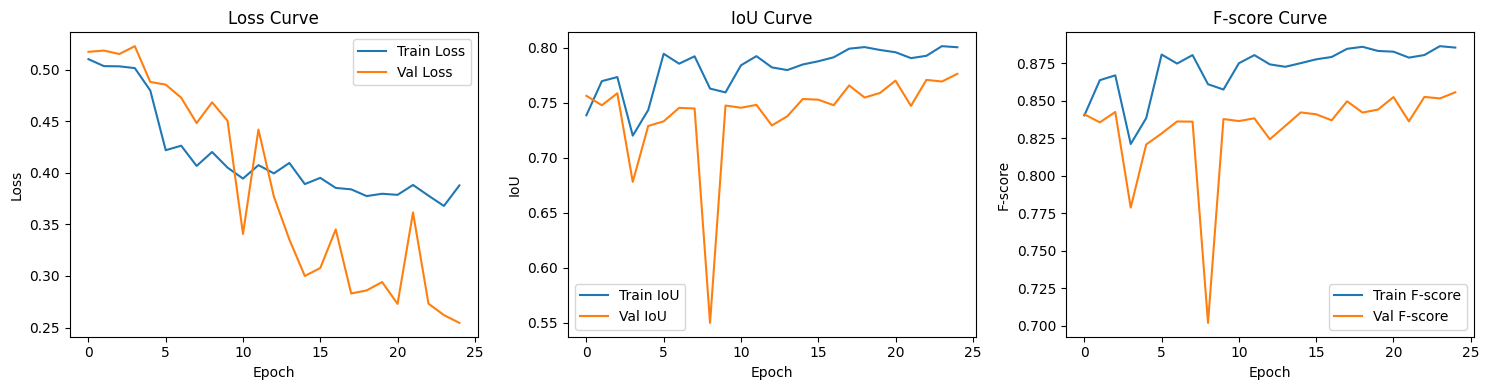

In [21]:
# Plot learning curves
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 3, 2)
plt.plot(train_ious, label='Train IoU')
plt.plot(val_ious, label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.title('IoU Curve')

plt.subplot(1, 3, 3)
plt.plot(train_fscores, label='Train F-score')
plt.plot(val_fscores, label='Val F-score')
plt.xlabel('Epoch')
plt.ylabel('F-score')
plt.legend()
plt.title('F-score Curve')

plt.tight_layout()
plt.show()


# Testing


Loading best model for testing...


Sliding Validation:   0%|          | 0/31 [00:00<?, ?it/s]


Test Results -> Loss: 0.2545, IoU: 0.7761, F-score (Dice): 0.8556

Plotting some test predictions...


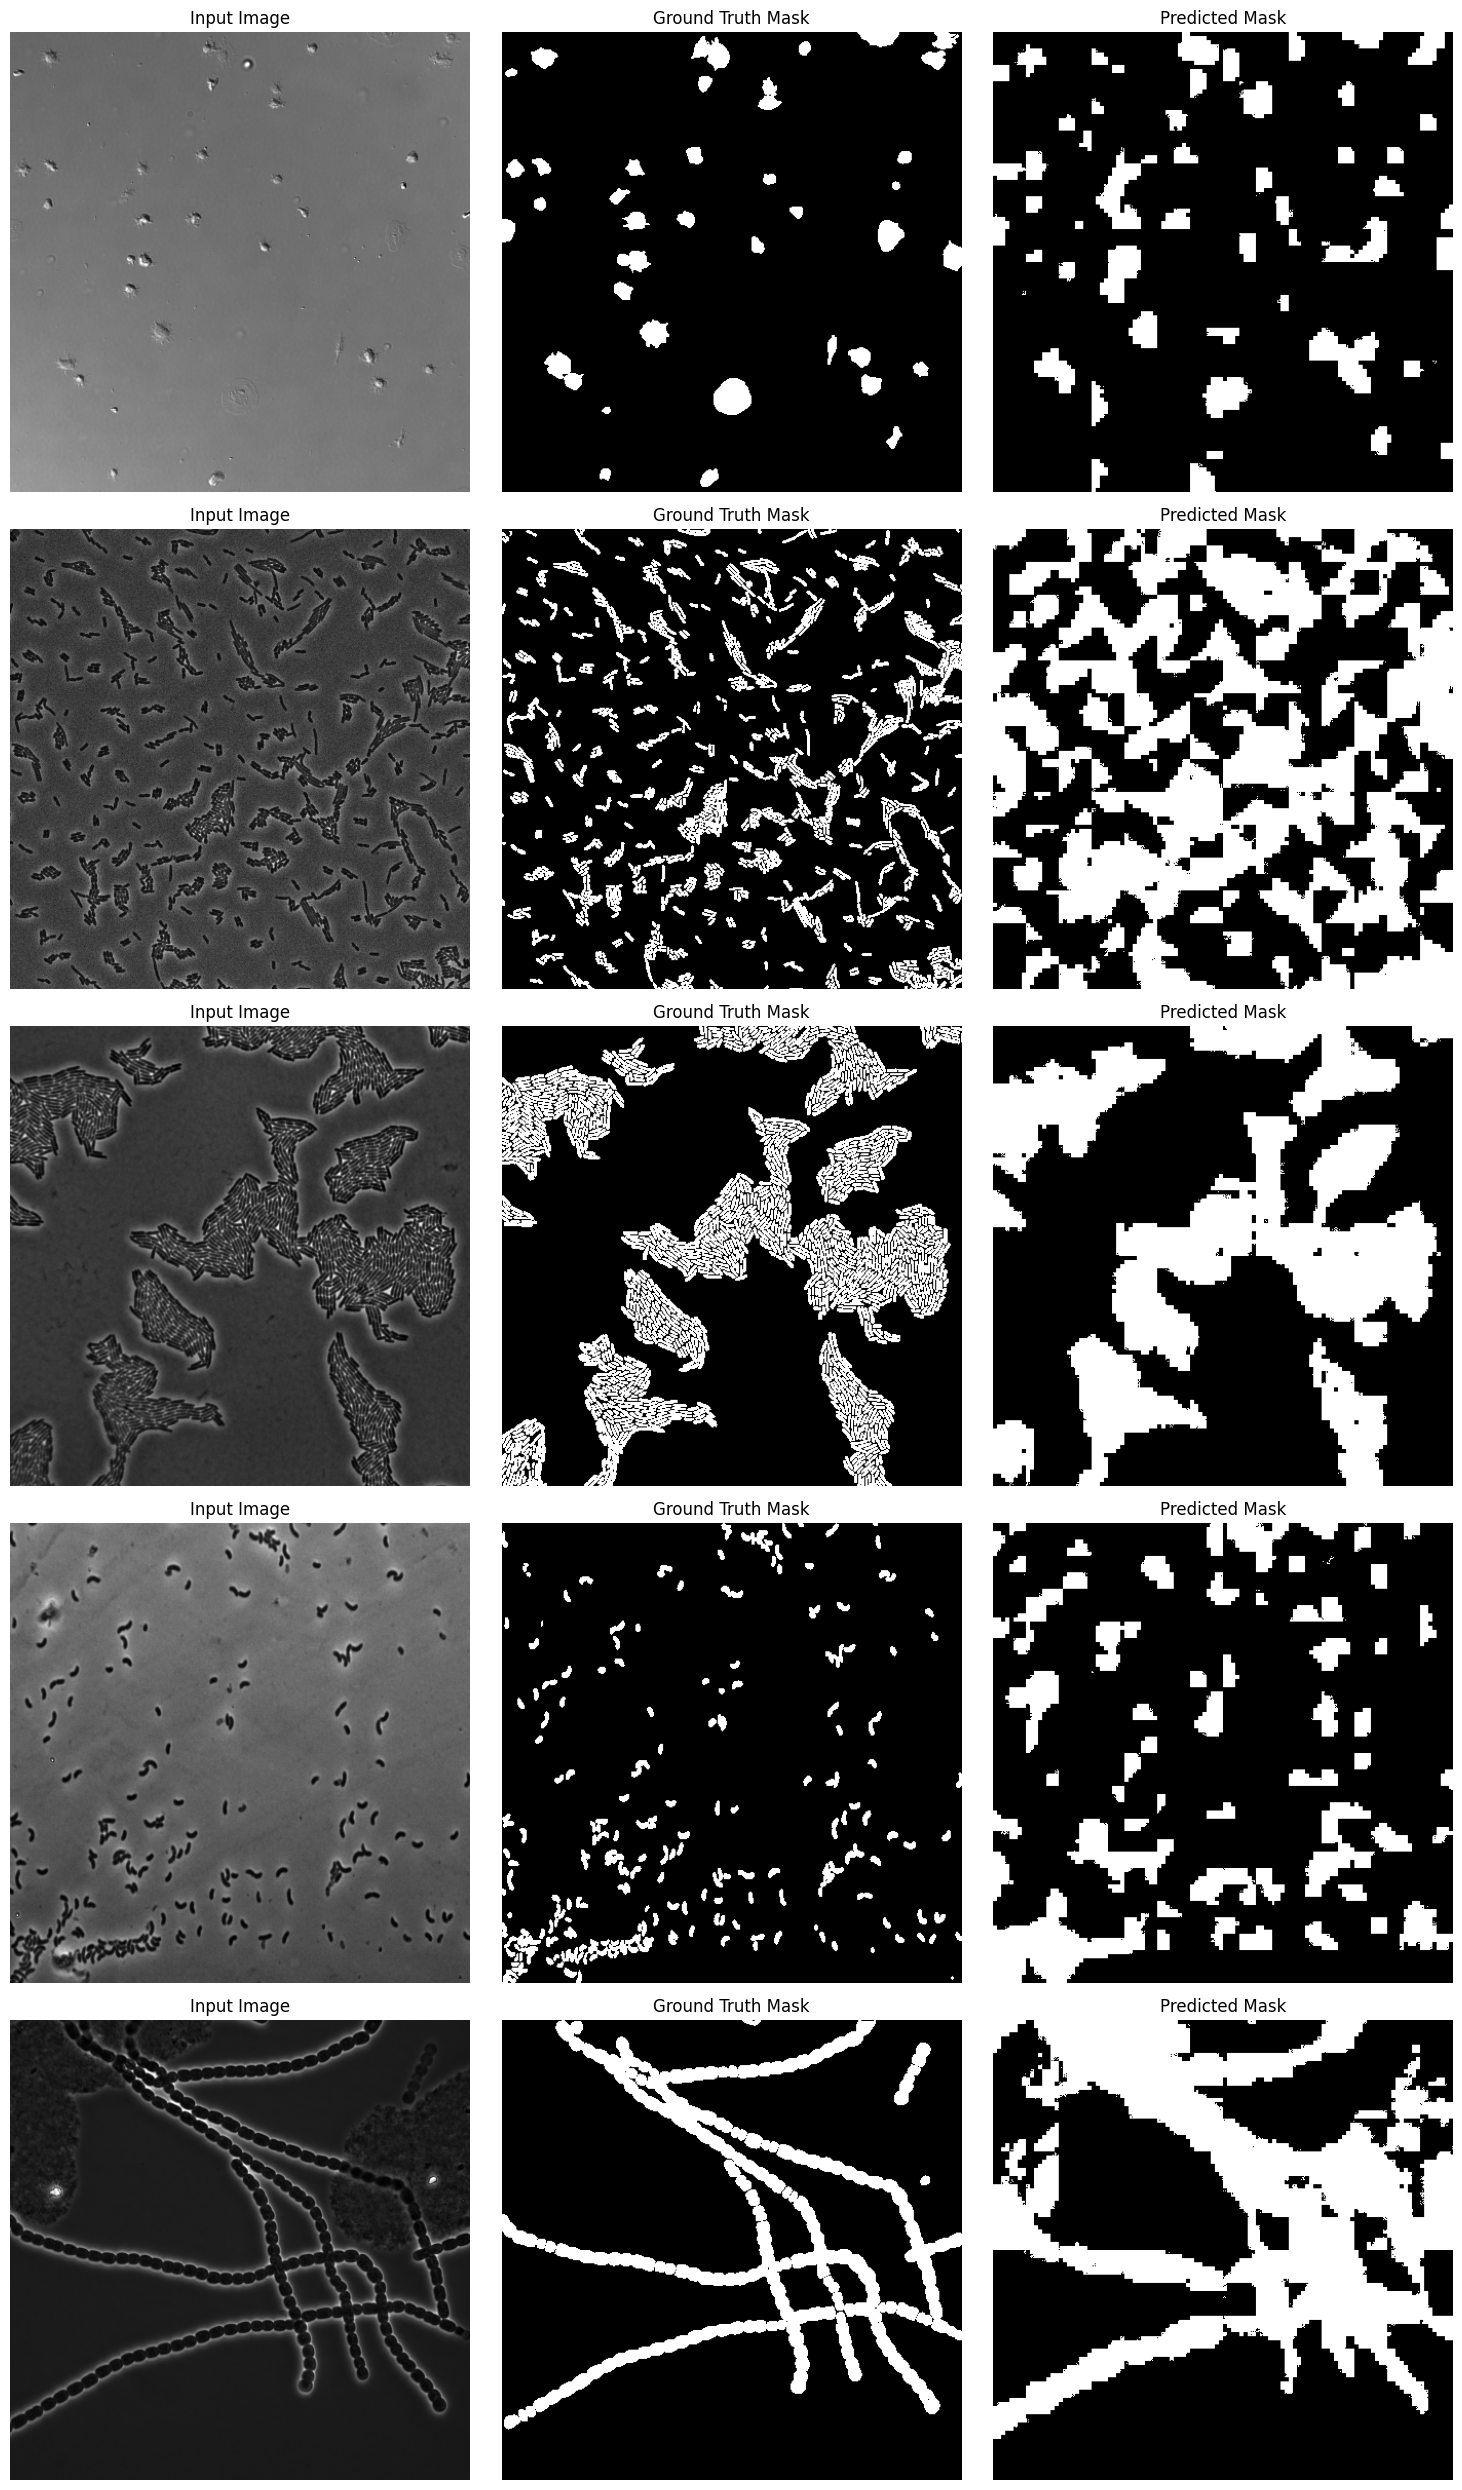

In [24]:
# Load best model
print("\nLoading best model for testing...")
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))

# Perform sliding window validation on the test dataset
test_loss, test_iou, test_fscore = validate_one_epoch_sliding(
    model,
    test_dataset,  # ✅ FIXED: Pass dataset, not dataloader
    loss_fn,
    metrics,
    DEVICE
)

# Print results
print(f"\nTest Results -> Loss: {test_loss:.4f}, IoU: {test_iou:.4f}, F-score (Dice): {test_fscore:.4f}")

# Plot predictions
print("\nPlotting some test predictions...")
plot_predictions(model, test_dataset, DEVICE, num_samples=5)